In [70]:
from pathlib import Path
import pandas as pd
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import joblib
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier, plot_tree, to_graphviz
#import cupy as cp
from sklearn.utils.class_weight import compute_sample_weight
import time
import os


In [63]:
# Load feature tables
test_path = Path("../data/leave-one-group-out-split/splits/").glob("test*.tsv")
train_path = Path("../data/leave-one-group-out-split/splits/").glob("train*.tsv")

test_tables = sorted(
    [(table.name, pd.read_csv(table, sep="\t")) for table in test_path]
)
train_tables = sorted(
    [(table.name, pd.read_csv(table, sep="\t")) for table in train_path]
)

# Do test and train match?
for i in range(0, 6):
    print(test_tables[i][0], train_tables[i][0])

test_dfs = [df for _, df in test_tables]
train_dfs = [df for _, df in train_tables]

stratified_test_path = "../data/combined-data-stratified-split/test_data.tsv"
stratified_train_path = "../data/combined-data-stratified-split/train_data.tsv"

test_dfs.append(pd.read_csv(stratified_test_path, sep="\t"))
train_dfs.append(pd.read_csv(stratified_train_path, sep="\t"))

test_split_0.tsv train_split_0.tsv
test_split_1.tsv train_split_1.tsv
test_split_2.tsv train_split_2.tsv
test_split_3.tsv train_split_3.tsv
test_split_4.tsv train_split_4.tsv
test_split_5.tsv train_split_5.tsv


In [ ]:
def format_splits(train_df, test_df, split):
    le = LabelEncoder()
    le.fit(["early", "middle", "late"]) 
    train_df["classification_x"] = le.fit_transform(train_df["classification_x"])
    test_df["classification_x"] = le.fit_transform(test_df["classification_x"])

    ## Check to see if the encodings are consistent between test and train split
    # train_encodings = sorted(
    #     set(
    #         zip(
    #             train_df["classification_x"],
    #             le.inverse_transform(train_df["classification_x"]),
    #         )
    #     )
    # )
    # test_encodings = sorted(
    #     set(
    #         zip(
    #             test_df["classification_x"],
    #             le.inverse_transform(test_df["classification_x"]),
    #         )
    #     )
    # )

    # print("Train encodings:")
    # for enc, label in train_encodings:
    #     print(f"{enc}: {label}")

    # print("\nTest encodings:")
    # for enc, label in test_encodings:
    #     print(f"{enc}: {label}")

    # if train_encodings != test_encodings:
    #     print("! Encodings do not match")

    # Select feature columns
    drop_cols = ["Unnamed: 0", "Geneid", "DNASequence", "classification_x"]

    if "group" in train_df.columns:
        drop_cols.append("group")

    feature_cols = train_df.drop(columns=drop_cols).columns

    X_train = train_df[feature_cols].copy()
    y_train = train_df["classification_x"].copy()

    X_test = test_df[feature_cols].copy()
    y_test = test_df["classification_x"].copy()

    result = (X_train, y_train, X_test, y_test, le, split)
    
    # save pickle
    filepath = "../data/xgboost/"
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    with open(f"../data/xgboost/split_{split}_data.pkl", "wb") as f:
        pickle.dump(result, f)
    

    return result

def run_xgboost(X_train, y_train, X_test, y_test, le, split):
    bst = XGBClassifier(objective="binary:logistic", seed=42)
    # fit model
    bst.fit(X_train, y_train)

    # save model
    joblib.dump(bst, f"../data/xgboost/model_split_{split}.joblib")

    # Print confusion matrix
    titles_options = [
        ("Confusion matrix, without normalization", None),
        ("Normalized confusion matrix", "true"),
    ]
    for title, normalize in titles_options:
        disp = ConfusionMatrixDisplay.from_estimator(
            bst, X_test, y_test, display_labels=le.classes_, normalize=normalize
        )
        disp.ax_.set_title(f"{title}, Split {split}")

        print(title)
        print(disp.confusion_matrix)

    plt.show()

In [105]:
def tune_model(X_train, y_train, X_test, y_test, le, split):
    ## Train model
    start_time = time.time()

    sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

    param_grid = {
    "max_depth": [3, 4, 5, 6, 7, 8, 9, 10, 11],
    "learning_rate": [0.3, 0.1, 0.05, 0.01, 0.005],
    "gamma": [0, 0.1, 0.25, 0.5, 1.0],
    "reg_lambda": [0, 0.1, 1, 5, 10, 20],
    "reg_alpha": [0, 0.1, 1, 5, 10, 20],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    }

    optimal_params = RandomizedSearchCV(
        estimator=XGBClassifier(
            objective="multi:softprob",
            num_class=3,
            seed=42,
            subsample=0.9,
            colsample_bytree=0.5,
            device="cuda",
        ),
        param_distributions=param_grid,
        scoring="roc_auc_ovr",
        n_iter=20,
        cv=3,
        n_jobs=10,
    )

    # Evaluate model
    optimal_params.fit(X_train, y_train)  # , sample_weight=sample_weights)

    print(optimal_params.best_params_)
    # {"reg_lambda": 1.0, "max_depth": 4, "learning_rate": 0.1, "gamma": 0}

    end_time = time.time()
    elapsed_time = end_time - start_time

    rf_optimized = optimal_params.best_estimator_
    y_pred = rf_optimized.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=["early", "late", "middle"]))

    ConfusionMatrixDisplay.from_estimator(rf_optimized, X_test, y_test)
    plt.title(f"Confusion Matrix for Split {split}")
    plt.tight_layout()
    plt.show()

    bt = rf_optimized.get_booster()
    for importance_type in ("weight", "total_gain", "total_cover", "gain", "cover"):
        print("%s: " % importance_type, bt.get_score(importance_type=importance_type))

    node_params = {"shape": "box", "style": "filled, rounded", "fillcolor": "#78cbef"}
    leaf_params = {"shape": "box", "style": "filled", "fillcolor": "#e48038"}

    #to_graphviz(
    #    rf_optimized,
    #    tree_idx=0,
    #    size="10,10",
    #    condition_node_params=node_params,
    #    leaf_node_params=leaf_params,
    #)

Spalten in train_df (0): ['Unnamed: 0', 'Geneid', 'DNASequence', 'classification_x', 'Gene_Position_Relative', 'GC_Content', 'Seq_length', 'A_Content', 'T_Content', 'G_Content', 'C_Content', 'Purin_Content', 'Pyrimidin_Content', 'CpG_bias', 'motive_TATA_box_rel', 'motive_CAAT_box_rel', 'motive_PolyA_signal_rel', 'kmer_AAA', 'kmer_AAT', 'kmer_AAG', 'kmer_AAC', 'kmer_ATA', 'kmer_ATT', 'kmer_ATG', 'kmer_ATC', 'kmer_AGA', 'kmer_AGT', 'kmer_AGG', 'kmer_AGC', 'kmer_ACA', 'kmer_ACT', 'kmer_ACG', 'kmer_ACC', 'kmer_TAA', 'kmer_TAT', 'kmer_TAG', 'kmer_TAC', 'kmer_TTA', 'kmer_TTT', 'kmer_TTG', 'kmer_TTC', 'kmer_TGA', 'kmer_TGT', 'kmer_TGG', 'kmer_TGC', 'kmer_TCA', 'kmer_TCT', 'kmer_TCG', 'kmer_TCC', 'kmer_GAA', 'kmer_GAT', 'kmer_GAG', 'kmer_GAC', 'kmer_GTA', 'kmer_GTT', 'kmer_GTG', 'kmer_GTC', 'kmer_GGA', 'kmer_GGT', 'kmer_GGG', 'kmer_GGC', 'kmer_GCA', 'kmer_GCT', 'kmer_GCG', 'kmer_GCC', 'kmer_CAA', 'kmer_CAT', 'kmer_CAG', 'kmer_CAC', 'kmer_CTA', 'kmer_CTT', 'kmer_CTG', 'kmer_CTC', 'kmer_CGA', 'k

c:\Users\luise\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:55:25] WARNING: D:\bld\xgboost-split_1737531313485\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


{'subsample': 0.9, 'reg_lambda': 1, 'reg_alpha': 0, 'max_depth': 9, 'learning_rate': 0.05, 'gamma': 0.5, 'colsample_bytree': 0.6}
              precision    recall  f1-score   support

       early       0.71      0.69      0.70        61
        late       0.75      0.86      0.80        92
      middle       0.75      0.64      0.69        78

    accuracy                           0.74       231
   macro avg       0.74      0.73      0.73       231
weighted avg       0.74      0.74      0.74       231



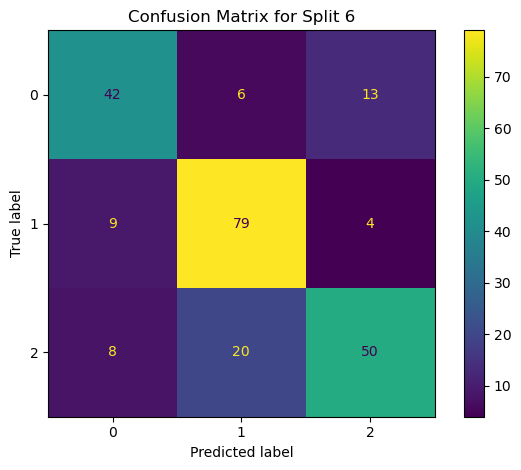

weight:  {'Gene_Position_Relative': 819.0, 'GC_Content': 143.0, 'Seq_length': 185.0, 'A_Content': 99.0, 'T_Content': 102.0, 'G_Content': 117.0, 'C_Content': 141.0, 'Purin_Content': 88.0, 'Pyrimidin_Content': 30.0, 'CpG_bias': 156.0, 'motive_TATA_box_rel': 55.0, 'motive_PolyA_signal_rel': 61.0, 'kmer_AAA': 145.0, 'kmer_AAT': 132.0, 'kmer_AAG': 99.0, 'kmer_AAC': 126.0, 'kmer_ATA': 157.0, 'kmer_ATT': 82.0, 'kmer_ATG': 114.0, 'kmer_ATC': 102.0, 'kmer_AGA': 111.0, 'kmer_AGT': 105.0, 'kmer_AGG': 121.0, 'kmer_AGC': 63.0, 'kmer_ACA': 155.0, 'kmer_ACT': 133.0, 'kmer_ACG': 119.0, 'kmer_ACC': 101.0, 'kmer_TAA': 80.0, 'kmer_TAT': 79.0, 'kmer_TAG': 95.0, 'kmer_TAC': 94.0, 'kmer_TTA': 96.0, 'kmer_TTT': 135.0, 'kmer_TTG': 175.0, 'kmer_TTC': 127.0, 'kmer_TGA': 182.0, 'kmer_TGT': 155.0, 'kmer_TGG': 93.0, 'kmer_TGC': 131.0, 'kmer_TCA': 122.0, 'kmer_TCT': 166.0, 'kmer_TCG': 69.0, 'kmer_TCC': 89.0, 'kmer_GAA': 109.0, 'kmer_GAT': 136.0, 'kmer_GAG': 156.0, 'kmer_GAC': 71.0, 'kmer_GTA': 120.0, 'kmer_GTT': 12

In [107]:
# fine tuning
for i, (train_df, test_df) in enumerate(zip(train_dfs, test_dfs)):
    print(f"Spalten in train_df ({i}):", train_df.columns.tolist())
    print(f"Spalten in test_df ({i}):", test_df.columns.tolist())

    if i == 6: 
        print("stratified Split")
        tune_model(*format_splits(train_df, test_df, i))

    else:
        print(f"Split {i}")
        #tune_model(*format_splits(train_df, test_df, i))

Spalten in train_df (0): ['Unnamed: 0', 'Geneid', 'DNASequence', 'classification_x', 'Gene_Position_Relative', 'GC_Content', 'Seq_length', 'A_Content', 'T_Content', 'G_Content', 'C_Content', 'Purin_Content', 'Pyrimidin_Content', 'CpG_bias', 'motive_TATA_box_rel', 'motive_CAAT_box_rel', 'motive_PolyA_signal_rel', 'kmer_AAA', 'kmer_AAT', 'kmer_AAG', 'kmer_AAC', 'kmer_ATA', 'kmer_ATT', 'kmer_ATG', 'kmer_ATC', 'kmer_AGA', 'kmer_AGT', 'kmer_AGG', 'kmer_AGC', 'kmer_ACA', 'kmer_ACT', 'kmer_ACG', 'kmer_ACC', 'kmer_TAA', 'kmer_TAT', 'kmer_TAG', 'kmer_TAC', 'kmer_TTA', 'kmer_TTT', 'kmer_TTG', 'kmer_TTC', 'kmer_TGA', 'kmer_TGT', 'kmer_TGG', 'kmer_TGC', 'kmer_TCA', 'kmer_TCT', 'kmer_TCG', 'kmer_TCC', 'kmer_GAA', 'kmer_GAT', 'kmer_GAG', 'kmer_GAC', 'kmer_GTA', 'kmer_GTT', 'kmer_GTG', 'kmer_GTC', 'kmer_GGA', 'kmer_GGT', 'kmer_GGG', 'kmer_GGC', 'kmer_GCA', 'kmer_GCT', 'kmer_GCG', 'kmer_GCC', 'kmer_CAA', 'kmer_CAT', 'kmer_CAG', 'kmer_CAC', 'kmer_CTA', 'kmer_CTT', 'kmer_CTG', 'kmer_CTC', 'kmer_CGA', 'k

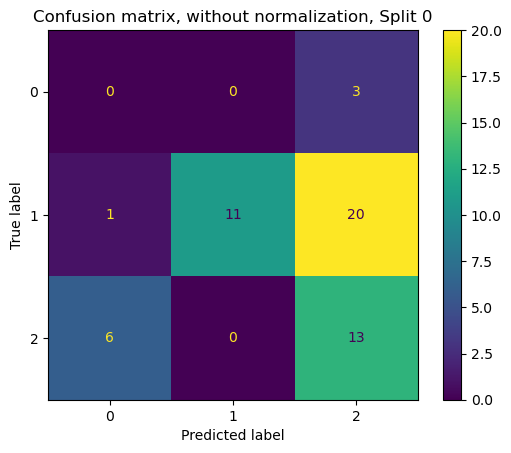

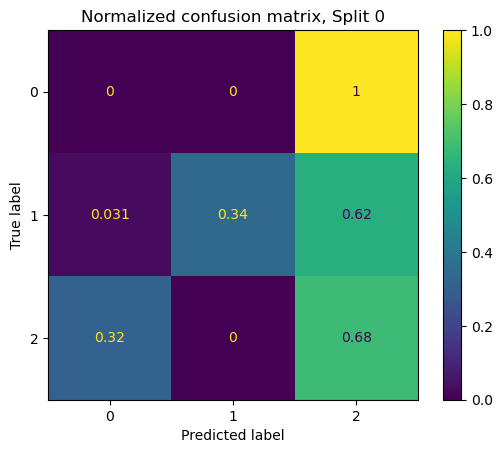

Spalten in train_df (1): ['Unnamed: 0', 'Geneid', 'DNASequence', 'classification_x', 'Gene_Position_Relative', 'GC_Content', 'Seq_length', 'A_Content', 'T_Content', 'G_Content', 'C_Content', 'Purin_Content', 'Pyrimidin_Content', 'CpG_bias', 'motive_TATA_box_rel', 'motive_CAAT_box_rel', 'motive_PolyA_signal_rel', 'kmer_AAA', 'kmer_AAT', 'kmer_AAG', 'kmer_AAC', 'kmer_ATA', 'kmer_ATT', 'kmer_ATG', 'kmer_ATC', 'kmer_AGA', 'kmer_AGT', 'kmer_AGG', 'kmer_AGC', 'kmer_ACA', 'kmer_ACT', 'kmer_ACG', 'kmer_ACC', 'kmer_TAA', 'kmer_TAT', 'kmer_TAG', 'kmer_TAC', 'kmer_TTA', 'kmer_TTT', 'kmer_TTG', 'kmer_TTC', 'kmer_TGA', 'kmer_TGT', 'kmer_TGG', 'kmer_TGC', 'kmer_TCA', 'kmer_TCT', 'kmer_TCG', 'kmer_TCC', 'kmer_GAA', 'kmer_GAT', 'kmer_GAG', 'kmer_GAC', 'kmer_GTA', 'kmer_GTT', 'kmer_GTG', 'kmer_GTC', 'kmer_GGA', 'kmer_GGT', 'kmer_GGG', 'kmer_GGC', 'kmer_GCA', 'kmer_GCT', 'kmer_GCG', 'kmer_GCC', 'kmer_CAA', 'kmer_CAT', 'kmer_CAG', 'kmer_CAC', 'kmer_CTA', 'kmer_CTT', 'kmer_CTG', 'kmer_CTC', 'kmer_CGA', 'k

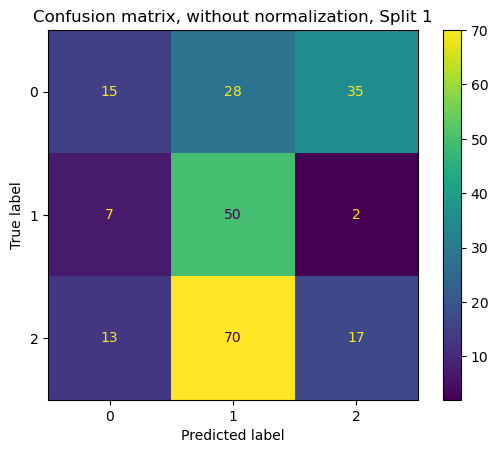

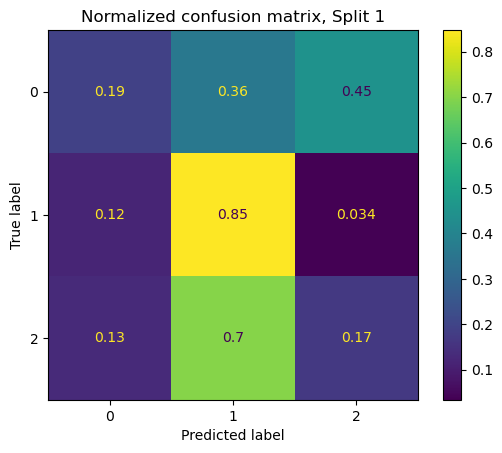

Spalten in train_df (2): ['Unnamed: 0', 'Geneid', 'DNASequence', 'classification_x', 'Gene_Position_Relative', 'GC_Content', 'Seq_length', 'A_Content', 'T_Content', 'G_Content', 'C_Content', 'Purin_Content', 'Pyrimidin_Content', 'CpG_bias', 'motive_TATA_box_rel', 'motive_CAAT_box_rel', 'motive_PolyA_signal_rel', 'kmer_AAA', 'kmer_AAT', 'kmer_AAG', 'kmer_AAC', 'kmer_ATA', 'kmer_ATT', 'kmer_ATG', 'kmer_ATC', 'kmer_AGA', 'kmer_AGT', 'kmer_AGG', 'kmer_AGC', 'kmer_ACA', 'kmer_ACT', 'kmer_ACG', 'kmer_ACC', 'kmer_TAA', 'kmer_TAT', 'kmer_TAG', 'kmer_TAC', 'kmer_TTA', 'kmer_TTT', 'kmer_TTG', 'kmer_TTC', 'kmer_TGA', 'kmer_TGT', 'kmer_TGG', 'kmer_TGC', 'kmer_TCA', 'kmer_TCT', 'kmer_TCG', 'kmer_TCC', 'kmer_GAA', 'kmer_GAT', 'kmer_GAG', 'kmer_GAC', 'kmer_GTA', 'kmer_GTT', 'kmer_GTG', 'kmer_GTC', 'kmer_GGA', 'kmer_GGT', 'kmer_GGG', 'kmer_GGC', 'kmer_GCA', 'kmer_GCT', 'kmer_GCG', 'kmer_GCC', 'kmer_CAA', 'kmer_CAT', 'kmer_CAG', 'kmer_CAC', 'kmer_CTA', 'kmer_CTT', 'kmer_CTG', 'kmer_CTC', 'kmer_CGA', 'k

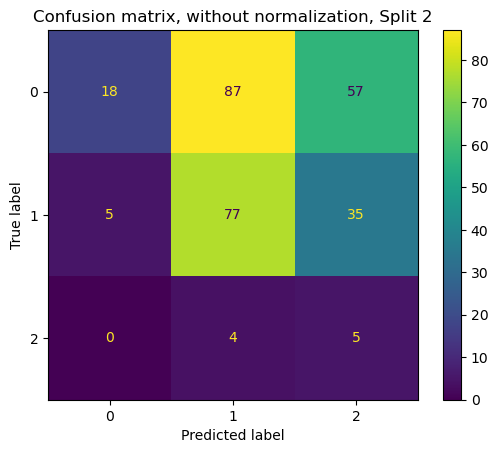

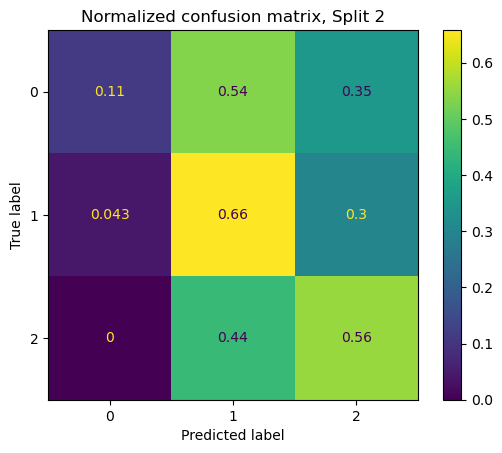

Spalten in train_df (3): ['Unnamed: 0', 'Geneid', 'DNASequence', 'classification_x', 'Gene_Position_Relative', 'GC_Content', 'Seq_length', 'A_Content', 'T_Content', 'G_Content', 'C_Content', 'Purin_Content', 'Pyrimidin_Content', 'CpG_bias', 'motive_TATA_box_rel', 'motive_CAAT_box_rel', 'motive_PolyA_signal_rel', 'kmer_AAA', 'kmer_AAT', 'kmer_AAG', 'kmer_AAC', 'kmer_ATA', 'kmer_ATT', 'kmer_ATG', 'kmer_ATC', 'kmer_AGA', 'kmer_AGT', 'kmer_AGG', 'kmer_AGC', 'kmer_ACA', 'kmer_ACT', 'kmer_ACG', 'kmer_ACC', 'kmer_TAA', 'kmer_TAT', 'kmer_TAG', 'kmer_TAC', 'kmer_TTA', 'kmer_TTT', 'kmer_TTG', 'kmer_TTC', 'kmer_TGA', 'kmer_TGT', 'kmer_TGG', 'kmer_TGC', 'kmer_TCA', 'kmer_TCT', 'kmer_TCG', 'kmer_TCC', 'kmer_GAA', 'kmer_GAT', 'kmer_GAG', 'kmer_GAC', 'kmer_GTA', 'kmer_GTT', 'kmer_GTG', 'kmer_GTC', 'kmer_GGA', 'kmer_GGT', 'kmer_GGG', 'kmer_GGC', 'kmer_GCA', 'kmer_GCT', 'kmer_GCG', 'kmer_GCC', 'kmer_CAA', 'kmer_CAT', 'kmer_CAG', 'kmer_CAC', 'kmer_CTA', 'kmer_CTT', 'kmer_CTG', 'kmer_CTC', 'kmer_CGA', 'k

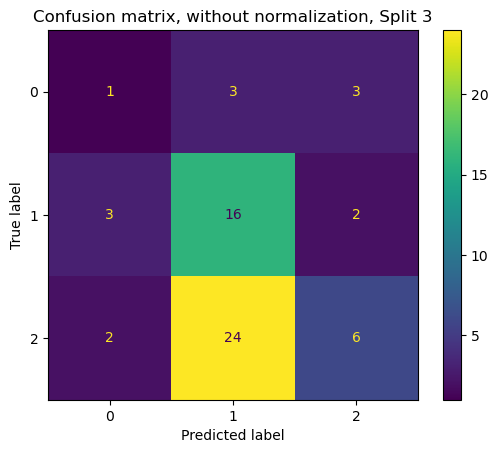

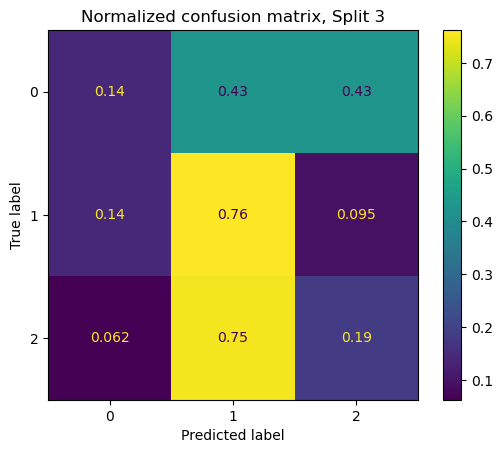

Spalten in train_df (4): ['Unnamed: 0', 'Geneid', 'DNASequence', 'classification_x', 'Gene_Position_Relative', 'GC_Content', 'Seq_length', 'A_Content', 'T_Content', 'G_Content', 'C_Content', 'Purin_Content', 'Pyrimidin_Content', 'CpG_bias', 'motive_TATA_box_rel', 'motive_CAAT_box_rel', 'motive_PolyA_signal_rel', 'kmer_AAA', 'kmer_AAT', 'kmer_AAG', 'kmer_AAC', 'kmer_ATA', 'kmer_ATT', 'kmer_ATG', 'kmer_ATC', 'kmer_AGA', 'kmer_AGT', 'kmer_AGG', 'kmer_AGC', 'kmer_ACA', 'kmer_ACT', 'kmer_ACG', 'kmer_ACC', 'kmer_TAA', 'kmer_TAT', 'kmer_TAG', 'kmer_TAC', 'kmer_TTA', 'kmer_TTT', 'kmer_TTG', 'kmer_TTC', 'kmer_TGA', 'kmer_TGT', 'kmer_TGG', 'kmer_TGC', 'kmer_TCA', 'kmer_TCT', 'kmer_TCG', 'kmer_TCC', 'kmer_GAA', 'kmer_GAT', 'kmer_GAG', 'kmer_GAC', 'kmer_GTA', 'kmer_GTT', 'kmer_GTG', 'kmer_GTC', 'kmer_GGA', 'kmer_GGT', 'kmer_GGG', 'kmer_GGC', 'kmer_GCA', 'kmer_GCT', 'kmer_GCG', 'kmer_GCC', 'kmer_CAA', 'kmer_CAT', 'kmer_CAG', 'kmer_CAC', 'kmer_CTA', 'kmer_CTT', 'kmer_CTG', 'kmer_CTC', 'kmer_CGA', 'k

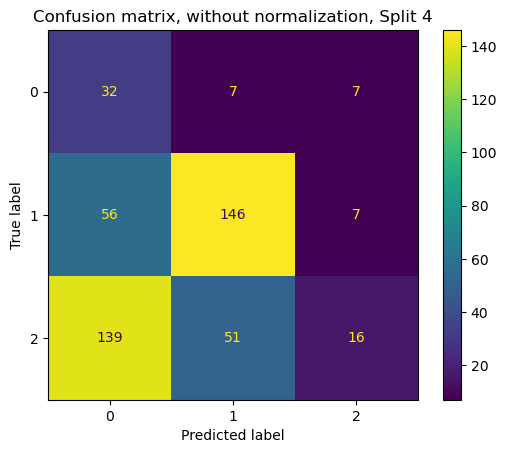

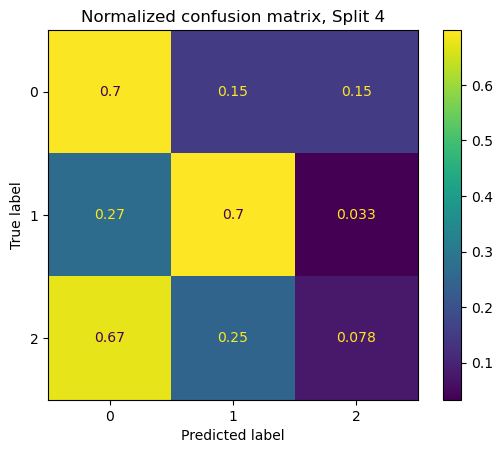

Spalten in train_df (5): ['Unnamed: 0', 'Geneid', 'DNASequence', 'classification_x', 'Gene_Position_Relative', 'GC_Content', 'Seq_length', 'A_Content', 'T_Content', 'G_Content', 'C_Content', 'Purin_Content', 'Pyrimidin_Content', 'CpG_bias', 'motive_TATA_box_rel', 'motive_CAAT_box_rel', 'motive_PolyA_signal_rel', 'kmer_AAA', 'kmer_AAT', 'kmer_AAG', 'kmer_AAC', 'kmer_ATA', 'kmer_ATT', 'kmer_ATG', 'kmer_ATC', 'kmer_AGA', 'kmer_AGT', 'kmer_AGG', 'kmer_AGC', 'kmer_ACA', 'kmer_ACT', 'kmer_ACG', 'kmer_ACC', 'kmer_TAA', 'kmer_TAT', 'kmer_TAG', 'kmer_TAC', 'kmer_TTA', 'kmer_TTT', 'kmer_TTG', 'kmer_TTC', 'kmer_TGA', 'kmer_TGT', 'kmer_TGG', 'kmer_TGC', 'kmer_TCA', 'kmer_TCT', 'kmer_TCG', 'kmer_TCC', 'kmer_GAA', 'kmer_GAT', 'kmer_GAG', 'kmer_GAC', 'kmer_GTA', 'kmer_GTT', 'kmer_GTG', 'kmer_GTC', 'kmer_GGA', 'kmer_GGT', 'kmer_GGG', 'kmer_GGC', 'kmer_GCA', 'kmer_GCT', 'kmer_GCG', 'kmer_GCC', 'kmer_CAA', 'kmer_CAT', 'kmer_CAG', 'kmer_CAC', 'kmer_CTA', 'kmer_CTT', 'kmer_CTG', 'kmer_CTC', 'kmer_CGA', 'k

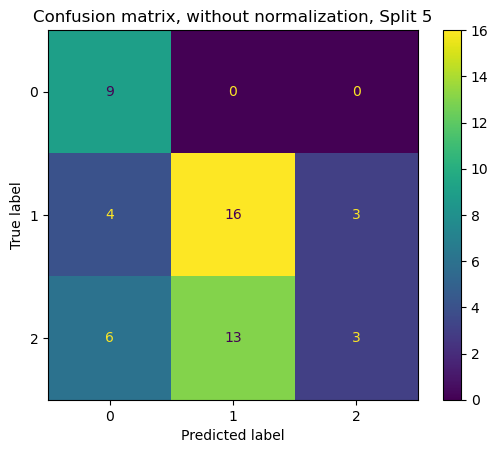

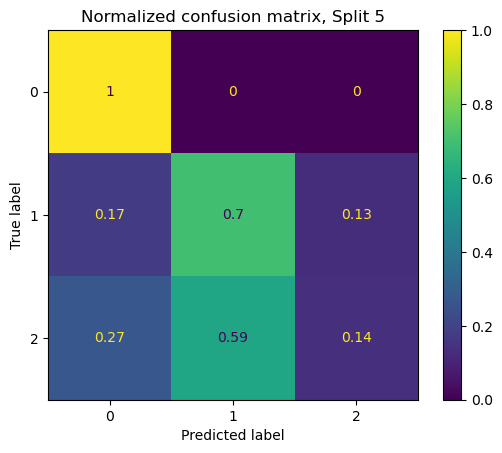

Spalten in train_df (6): ['Unnamed: 0', 'Geneid', 'DNASequence', 'classification_x', 'Gene_Position_Relative', 'GC_Content', 'Seq_length', 'A_Content', 'T_Content', 'G_Content', 'C_Content', 'Purin_Content', 'Pyrimidin_Content', 'CpG_bias', 'motive_TATA_box_rel', 'motive_CAAT_box_rel', 'motive_PolyA_signal_rel', 'kmer_AAA', 'kmer_AAT', 'kmer_AAG', 'kmer_AAC', 'kmer_ATA', 'kmer_ATT', 'kmer_ATG', 'kmer_ATC', 'kmer_AGA', 'kmer_AGT', 'kmer_AGG', 'kmer_AGC', 'kmer_ACA', 'kmer_ACT', 'kmer_ACG', 'kmer_ACC', 'kmer_TAA', 'kmer_TAT', 'kmer_TAG', 'kmer_TAC', 'kmer_TTA', 'kmer_TTT', 'kmer_TTG', 'kmer_TTC', 'kmer_TGA', 'kmer_TGT', 'kmer_TGG', 'kmer_TGC', 'kmer_TCA', 'kmer_TCT', 'kmer_TCG', 'kmer_TCC', 'kmer_GAA', 'kmer_GAT', 'kmer_GAG', 'kmer_GAC', 'kmer_GTA', 'kmer_GTT', 'kmer_GTG', 'kmer_GTC', 'kmer_GGA', 'kmer_GGT', 'kmer_GGG', 'kmer_GGC', 'kmer_GCA', 'kmer_GCT', 'kmer_GCG', 'kmer_GCC', 'kmer_CAA', 'kmer_CAT', 'kmer_CAG', 'kmer_CAC', 'kmer_CTA', 'kmer_CTT', 'kmer_CTG', 'kmer_CTC', 'kmer_CGA', 'k

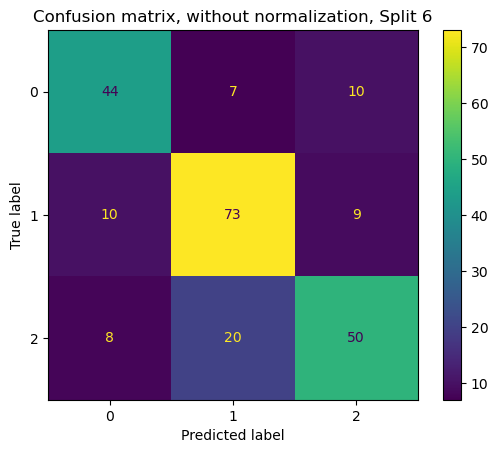

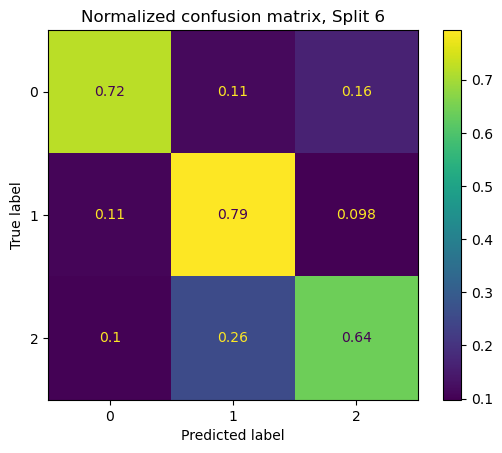

In [ ]:
# run xgboost
for i, (train_df, test_df) in enumerate(zip(train_dfs, test_dfs)):
    print(f"Spalten in train_df ({i}):", train_df.columns.tolist())
    print(f"Spalten in test_df ({i}):", test_df.columns.tolist())

    if i == 6: 
        print("stratified Split")
        run_xgboost(*format_splits(train_df, test_df, i))

    else:
        print(f"Split {i}")
        run_xgboost(*format_splits(train_df, test_df, i))
